**Part 3 - Mapping Closure in 2D for f_BZ using layers**

This notebook implements the mapping closure developed by (Chen, H. 1989) and extended by (Pope, S.B. 1991) for a two-dimensional (2D) problem where the vector of random variables $\bm{Y} = (B,Z)$ includes the buoyancy $B$ and the vertical height $Z$. Distinct however from (Pope, S.B. 1991) we will only treat $B$ using the mapping closure.


*Evolution equation*

The joint pdf $f_{\bm{Y}}$ evolves according to the forward Kolmogorov equation given by

\begin{equation}
\frac{\partial f_{\bm{Y}} }{ \partial t}= -\frac{\partial }{\partial y_i} \bm{D}^{(1)}_i f_{\bm{Y}}  + \frac{\partial^{2}}{\partial y_i \partial y_j} \bm{D}^{(2)}_{ij} f_{\bm{Y}},
\end{equation}

where 

\begin{equation}
  \bm{D}^{(1)}=
  \phi\,\mathbb{E}_{\bm{Y}_{t}|\partial\Omega}
 \begin{bmatrix}
 0 \\
 \alpha_{1}\,\bm{n}\cdot\nabla B_{t} \\
 \end{bmatrix}
  \frac{f_{\bm{Y}|\partial\Omega}}{f_{\bm{Y}}} .
\end{equation}

arises due to diffusive fluxes at the boundary, which must be specified. The diffusion term for our system us given by either
\begin{equation}
  \bm{D}^{(2)}=-\alpha_{1}
  \mathbb{E}_{\bm{Y}_{t}}
    \begin{bmatrix}
    -1 & 0 \\
    0 & |\nabla B_{t}|^{2}\\
  \end{bmatrix},
\end{equation}
or
\begin{equation}
  \bm{D}^{(2)}=-\alpha_{1}
  \mathbb{E}_{\bm{Y}_{t}}
    \begin{bmatrix}
    0 & \partial_Z B_t/2 \\
    \partial_Z B_t/2  & |\nabla B_{t}|^{2}\\
  \end{bmatrix}.
\end{equation}

For now we will ignore $\bm{D}^{(1)}=0$, set $\alpha_1=1$ and work with the first formulation of $\bm{D}^{(2)}$ which provides the equation 
\begin{equation*}
    \frac{\partial f_{BZ}}{\partial t} = \frac{\partial^2 f_{BZ}}{\partial z^2} - \frac{\partial^2 }{\partial b^2} \left( \mathbb{E}_{BZ} [ |\nabla B|^2 ] f_{BZ} \right),
\end{equation*}
which contains one conditional average requiring closure. As $f_{B|Z} = f_{BZ}$ (for the case of $f_Z=1$) we will apply the mapping closure in $b$ only. Discretising the sample space $z$ into $N$ levels $(z_0, z_1, \cdots z_{N-1})$ we will consider the previous equation at each level $z_i$ by using the conditional mapping condition
\begin{equation*}
F_{B|Z=z_i}(\mathscr{Y}_i(\eta,t),t) = G(\eta),
\end{equation*}
such that a different equation for the mapping $\mathscr{Y}_i$ must be solved at each vertical level.
 

To formulate the $N-2$ mapping equations (as the mappings $\mathscr{Y}_0, \mathscr{Y}_{N-1}$ are specified a priori from the boundary conditions) we apply the chain rule
\begin{equation*}
\frac{\partial }{\partial b} \left( \frac{\partial \mathscr{Y}_i }{\partial t} f_{B|Z=z_i} \right) = - \frac{\partial f_{B|Z=z_i}}{\partial b},
\end{equation*} 
Substituting this into the previous equation gives
\begin{equation*}
    \frac{\partial }{\partial b} \left( \frac{\partial \mathscr{Y}_i }{\partial t} f_{B|Z=z_i} \right) = - \frac{\partial^2 f_{B|Z=z_i}}{\partial z^2} + \frac{\partial^2 }{\partial b^2} \left( \mathbb{E}_{B|Z=z_i} [ |\nabla B|^2 ] f_{B|Z=z_i} \right).
\end{equation*}
Integrating w.r.t $b$ and dividing through by $1/f_{B|Z=z_i}$ we obtain
\begin{equation*}
    \frac{\partial \mathscr{Y}_i }{\partial t} = -\frac{1}{f_{B|Z=z_i}} \int_0^{b=\mathscr{Y}_i} \left( \frac{\partial^2 f_{B|Z=z_i}}{\partial z^2} \right) db + \frac{1}{f_{B|Z=z_i}} \frac{\partial }{\partial b} \left( \mathbb{E}_{B|Z=z_i} [ |\nabla B|^2 ] f_{B|Z=z_i} \right).
\end{equation*}
Applying the mapping closure to the second term (see equations (11)-(16) of the overleaf notes) gives
\begin{equation*}
    \frac{\partial \mathscr{Y}_i }{\partial t} = -\frac{1}{f_{B|Z=z_i}} \int_0^{b=\mathscr{Y}_i} \left( \frac{\partial^2 f_{B|Z=z_i}}{\partial z^2} \right) db + \frac{1}{\tau_i} \left( -\eta \frac{\partial \mathscr{Y}_i }{\partial \eta} + \frac{\partial^2 \mathscr{Y}_i }{\partial \eta^2} \right).
\end{equation*}
Finally differentiating the mapping condition gives
\begin{equation*}
f_{B|Z=z_i}(\mathscr{Y}_i(\eta,t),t) \frac{\partial \mathscr{Y}_i}{\partial \eta} = g(\eta),
\end{equation*}
which allows us to write the first term in the mapping equation as
\begin{equation*}
    \frac{\partial \mathscr{Y}_i }{\partial t} = -\frac{\bm{D}^{(0)}(\mathscr{Y}_i)}{g(\eta)} \frac{\partial \mathscr{Y}_i}{\partial \eta} + \frac{1}{\tau_i} \left( -\eta \frac{\partial \mathscr{Y}_i }{\partial \eta} + \frac{\partial^2 \mathscr{Y}_i }{\partial \eta^2} \right),
\end{equation*} 
where $\bm{D}^{(0)}(\mathscr{Y}_i)$ is approximated using finite differences as
\begin{equation*}
\bm{D}^{(0)}(\mathscr{Y}_i(\eta,t)) = \int_0^{b=\mathscr{Y}_i} \left( \frac{ f_{B|Z=z_{i+1}} -2f_{B|Z=z_i} + f_{B|Z=z_{i-1}}}{\Delta z^2}\right) db.
\end{equation*}

**Setup**

We first import the required libraries to implement this model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Currently all the code is written using Z for \mathscr{Y} and z for \eta I must change this

We then define a computation grid for $f_{BZ}$ in terms of $b,z$, which for generality we write as $f_{\bm{Y}}$ with $\bm{y} = y_1,y_2$

In [13]:
# Boundary conditions
bc1 = 'Neumann'
bc2 = 'Dirichlet'

# Numerical resolution
N1 = 64
N2 = 32

# Domain
b = np.linspace(-2, 2, N1)  # b
z = np.linspace(0, 1, N2)  # z

Subsequently for the mapping equation we define a computational grid $\eta$ on which the Gaussian random variables is defined. 

In [14]:
# Time scales (cf. Taylor microscale)
t1 = 1

# Boundary conditions
bc1 = 'Neumann'

# Domain
η = np.linspace(-2, 2, len(b))  # b_i

*Differential operators*

To define the differential operators in the equations right hand sides we first define the gradient and Laplacian operators:

In [15]:
# Define the gradient & Laplacian operators
def grad(x):
  """Gradient operator ∂/∂x"""
  N = len(x)
  dx= x[1] - x[0] 
  D = np.zeros((N,N))
  for i in range(N):
    if i < N-1:
      D[i,i+1] = 1
    if i > 0:
      D[i,i-1] =-1
  return D/(2*dx)

def laplacian(x, bcs = 'Dirichlet'):
  """Laplacian ∂^2/∂x^2"""
  
  N = len(x)
  dx= x[1] - x[0] 

  L = np.zeros((N,N))
  for i in range(N):

    L[i,i] = -2.
    if i ==N-1:
      if bcs == 'Dirichlet':
        L[i,i-1] = 1
      elif bcs == 'Neumann':
        L[i,i-1] = 2
    elif i == 0:
      if bcs == 'Dirichlet':
        L[i,i+1] = 1
      elif bcs == 'Neumann':
        L[i,i+1] = 2
    else:
      L[i,i-1] = 1
      L[i,i+1] = 1

  return L/(dx**2)

def test_derivatives():
  """Check the derivatives are correctly implemented"""
  
  x = np.linspace(0, 2*np.pi, 256)
  
  D = grad(x)
  error_D = ( np.cos(x)[1:-1] - D.dot(np.sin(x))[1:-1])**2
  assert np.trapz(y=error_D,x=x[1:-1]) < 1e-07

  L = laplacian(x)
  error_L = (-np.sin(x)[1:-1] - L.dot(np.sin(x))[1:-1])**2
  assert np.trapz(y=error_L,x=x[1:-1]) < 1e-07

  return None

test_derivatives()

Then we define the Gaussian reference fields

In [16]:
from scipy.special import erf

def G(η):
    """Cumulative Gaussian distribution."""
    return (1+erf(η/np.sqrt(2)))/2

def g(η):
    """Gaussian distribution."""
    return np.exp(-η**2/2)/np.sqrt(2*np.pi)

Using these operators we construct the right hand side for a given level $z_i$ in terms of two routines, the first which treats the diffusion in $z$ we call $\texttt{diffusionZ}$ and the second which treats the diffusion in $b$ using the mapping closure called $\texttt{diffusionB}$.

In [21]:
def diffusionZ(f_Y,b,z,i,BC):

  Δz = z[1] - z[0]
  Nz = len(z)  
  
  if i == 1:
    f_Y[:,i-1] = BC(b, z=0)
    return (f_Y[:,i+1] - 2*f_Y[:,i] + f_Y[:,i-1])/(Δz**2)
  elif i == Nz-2:
    f_Y[:,i+1] = BC(b, z=1)
    return (f_Y[:,i+1] - 2*f_Y[:,i] + f_Y[:,i-1])/(Δz**2)
  else:
    return (f_Y[:,i+1] - 2*f_Y[:,i] + f_Y[:,i-1])/(Δz**2)

def diffusionB(X_n,η, τ = 10):
  
  # a) Mapping term for B diffusion
  D_η = grad(η)
  L_η = laplacian(η)
  L = (1./τ)*( -np.diag(η)@D_η + L_η )

  return L@X_n

def solve_Zi(f,b,z,X,η,i,Δt,BC):

  # a) Compute diffusion from B
  diffB = diffusionB(X[:,i],η)

  # b) Compute diffusion from ZdfYdt_diff_z & interpolate it onto mapping grid
  diffZ = diffusionZ(f,b,z,i,BC)
  diffZ = np.interp(X[:,i], b, np.cumsum(diffZ))

  # c) Update the mapping X^{n+1}
  X_new = X[:,i] + Δt*diffB - Δt*(diffZ/g(η))*grad(η)@X[:,i] #

  # D) Update f^{n+1} from X^{n+1}
  f_new = np.interp(x=b, xp=X_new, fp=g(η)/(grad(η)@X_new))
  
  return f_new, X_new

Having developed a means to evaluate the right hand side we now write a first order Euler time-stepping routine

In [22]:
def solver(f_Y,b,z,X,η,T,Δt, BC):

  N_z = len(z)

  f_Y_frames = []
  f_Y_frames.append(f_Y)

  X_frames = []
  X_frames.append(X)

  # Loop over all time instants
  for n,t in enumerate(T):
    
    # 0) Plot the system out
    if n%(len(T)//10) == 0:
      print('t = %3.3f \n' % t)
      fig, ax = plt.subplots()
      cf = ax.pcolormesh(b,z,f_Y.T, cmap='Reds')#, norm='log')
      fig.colorbar(cf, ax=ax)
      ax.set_xlabel('$b$')
      ax.set_ylabel('$z$')
      plt.show()

    # 1) Update the density f_Y due to diffusion in z, level by level
    for i,z_i in enumerate(z):
      if i == 0:
        f_Y[:,i] = BC(b,z=0)
        X[:,i] = 1 + 0.1*η
      elif i == N_z-1:
        f_Y[:,i] = BC(b,z=1)
        X[:,i] = -1 + 0.1*η
      else:
        f_Y[:,i], X[:,i] = solve_Zi(f_Y_frames[n],b,z,X_frames[n],η,i,Δt,BC)

    # 3) Grab the system state
    f_Y_frames.append(f_Y)
    X_frames.append(X)

  return None

Finally we specify the boundary conditions in terms of the callable $\texttt{BC}$

In [23]:
def BC(b,z):
    μ_0 = 1
    μ_1 = -1 
    Σ = 0.1
    
    if z == 0:
        return np.exp(-.5*( (b - μ_0)/Σ)**2 )/(Σ*np.sqrt(2*np.pi))
    elif z == 1:
        return np.exp(-.5*( (b - μ_1)/Σ)**2 )/(Σ*np.sqrt(2*np.pi))
    else:
        return 0*b

We then specify a discrete time interval and time-step the system

t = 0.000 



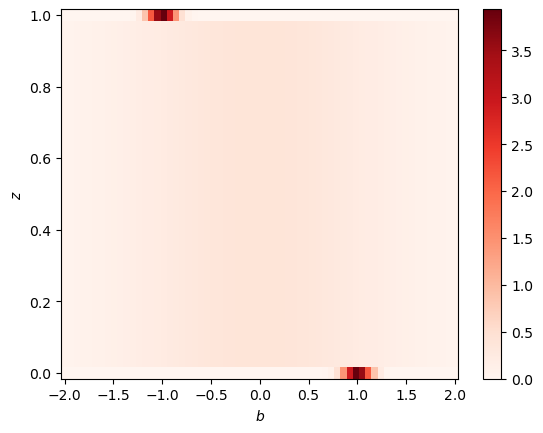

t = 0.010 



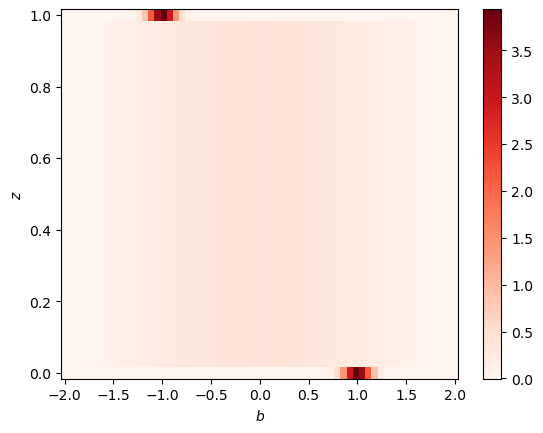

t = 0.020 



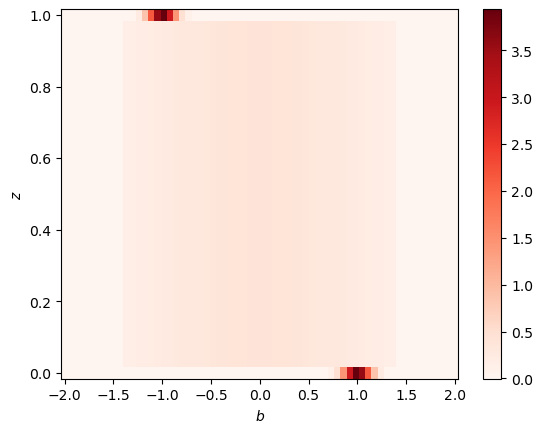

t = 0.030 



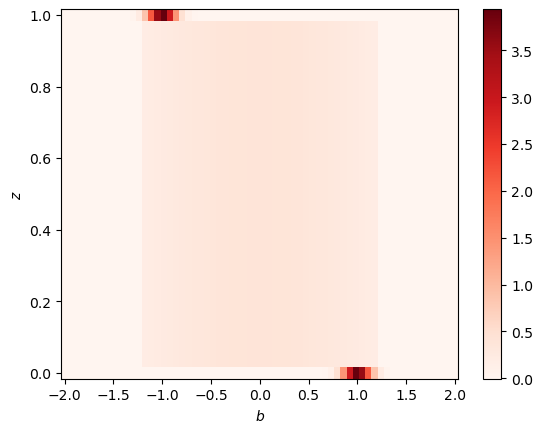

t = 0.040 



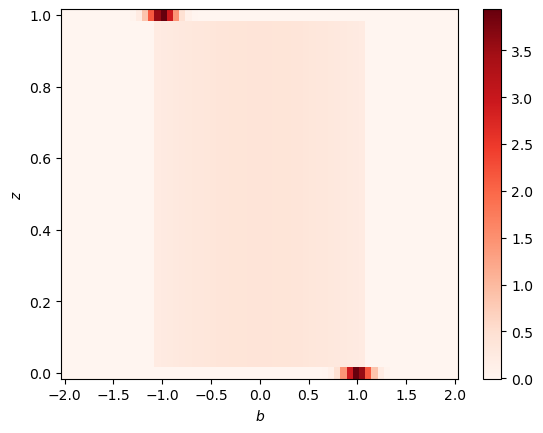

t = 0.050 



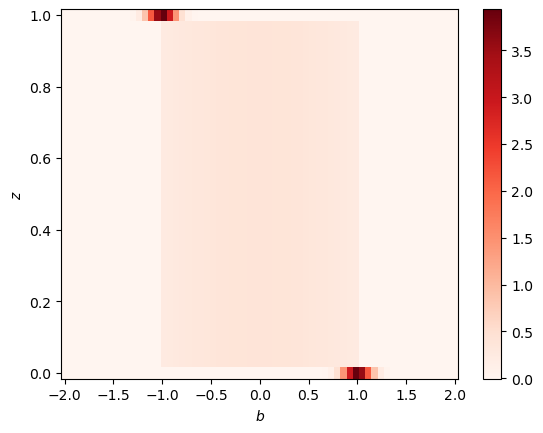

t = 0.060 



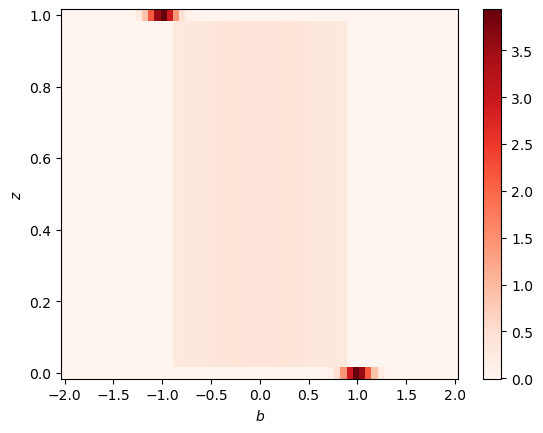

t = 0.070 



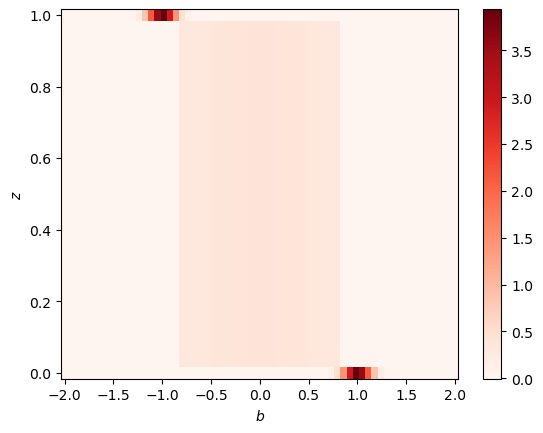

t = 0.080 



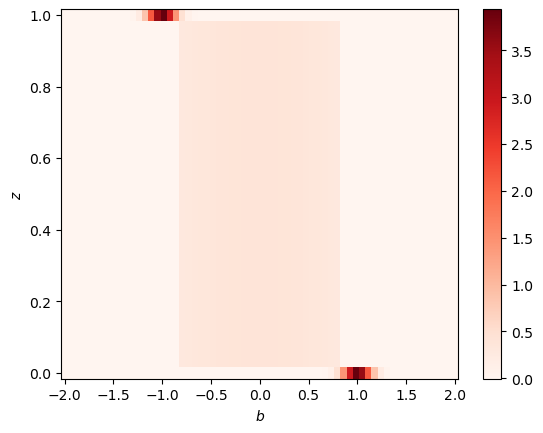

t = 0.090 



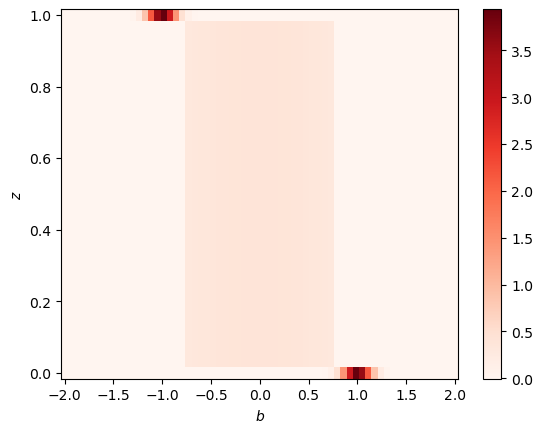

In [25]:
N_T = 10**3
T, Δt = np.linspace( 0,0.1,N_T,retstep=True)

# Initial conditions for f_Y shape b, z
f_Y = np.zeros((len(b),len(z)))
for i,z_i in enumerate(z):
    if i == 0:
        f_Y[:,i] = BC(b,z=0)
    elif i == len(z)-1:
        f_Y[:,i] = BC(b,z=1)
    else:
        f_Y[:,i] = g(b)

# Initial conditions for mapping X shape η, z
X = np.zeros((len(η),len(z)))
for i,z_i in enumerate(z):
    if i == 0:
        X[:,i] = 1 + 0.1*η
    elif i == len(η)-1:
        X[:,i] = -1 + 0.1*η
    else:
        X[:,i] = η

solver(f_Y,b,z,X,η,T,Δt, BC)